In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchviz import make_dot
from torchsummary import summary
import torchvision
from tqdm import tqdm
import pytorch_msssim # Structural Similarity Index (SSIM) Loss
import torch.nn.functional as F
import cv2

In [2]:
data_path = '/home/pradip/Desktop/image_rec/images'

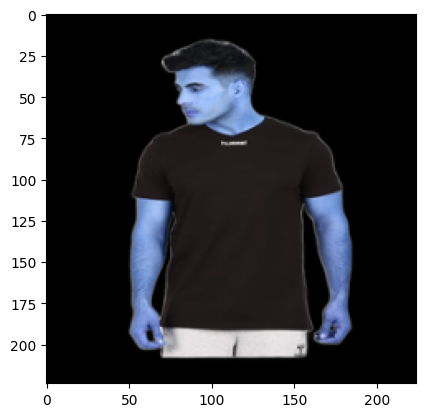

In [3]:
img = cv2.imread(f'{data_path}/t-shirts/mp000000009495477.png', cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [4]:
def compute_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size (number of images)
        images = images.view(batch_samples, images.shape[1], -1)  # Flatten HxW
        
        mean += images.mean(dim=[0, 2]) * batch_samples
        std += images.std(dim=[0, 2]) * batch_samples
        total_samples += batch_samples
    
    mean /= total_samples
    std /= total_samples
    return mean, std

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


dataset = torchvision.datasets.ImageFolder(root=data_path, transform=train_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

mean, std = compute_mean_std(loader)
print(f"Mean: {mean.tolist()}")
print(f"Std: {std.tolist()}")

Mean: [0.23731942474842072, 0.20981678366661072, 0.19925661385059357]
Std: [0.3304782807826996, 0.2958895266056061, 0.28353068232536316]


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])


train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(
            self,
            img_size,
            laten_dim = 256,
            kernel_1_size=5,
            kernel_2_size=3,
            kernel_3_size=3,
            padding_1=2,
            padding_2=1,
            padding_3=1,
            stride_1=1,
            stride_2=1,
            stride_3=1,
            max_pool_kernel_size=2,
            max_pool_stride=2
    ):
        super(AutoEncoder, self).__init__()

        self.img_size = img_size
        self.laten_dim = laten_dim

        self.kernel_1_size = kernel_1_size
        self.kernel_2_size = kernel_2_size
        self.kernel_3_size = kernel_3_size

        self.padding_1 = padding_1
        self.padding_2 = padding_2
        self.padding_3 = padding_3

        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.stride_3 = stride_3
        
        self.max_pool_kernel_size = max_pool_kernel_size
        self.max_pool_stride = max_pool_stride

        self.layer_norm_1_size = (img_size - kernel_1_size + 2 * padding_1) // stride_1 + 1 
        self.max_pool_1_size = (self.layer_norm_1_size - max_pool_kernel_size) // max_pool_stride + 1 
        self.layer_norm_2_size = (self.max_pool_1_size - kernel_2_size + 2 * padding_2) // stride_2 + 1
        self.max_pool_2_size = (self.layer_norm_2_size - max_pool_kernel_size) // max_pool_stride + 1
        self.layer_norm_3_size = (self.max_pool_2_size - kernel_3_size + 2 * padding_3) // stride_3 + 1
        self.max_pool_3_size = (self.layer_norm_3_size - max_pool_kernel_size) // max_pool_stride + 1
        
        check_even = (
            self.layer_norm_1_size | self.max_pool_1_size | self.layer_norm_2_size |
            self.max_pool_2_size | self.layer_norm_3_size | self.max_pool_3_size
        )
        if check_even & 1:
            raise ValueError(
                '''Put the value of each kernel size, padding, stride, max_pool kernel size and max_pool stride such that every Conv2d, MaxPool2d and Upsample gives even size in output'''
            )

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=self.kernel_1_size, padding=self.padding_1, stride=self.stride_1), 
            nn.ReLU(),
            nn.LayerNorm([6, self.layer_norm_1_size, self.layer_norm_1_size]),
            nn.MaxPool2d(kernel_size=self.max_pool_kernel_size, stride=self.max_pool_stride),

            nn.Conv2d(6, 8, kernel_size=self.kernel_2_size, padding=self.padding_2, stride=stride_2),
            nn.ReLU(),
            nn.LayerNorm([8, self.layer_norm_2_size, self.layer_norm_2_size]),
            nn.MaxPool2d(kernel_size=self.max_pool_kernel_size, stride=self.max_pool_stride),

            nn.Conv2d(8, 10, kernel_size=self.kernel_3_size, padding=self.padding_3, stride=self.stride_3),
            nn.ReLU(),
            nn.LayerNorm([10, self.layer_norm_3_size, self.layer_norm_3_size]), 
            nn.MaxPool2d(kernel_size=self.max_pool_kernel_size, stride=self.max_pool_stride),

            nn.Flatten(),
            nn.Linear(10 * self.max_pool_3_size * self.max_pool_3_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.laten_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.laten_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 10 * self.max_pool_3_size * self.max_pool_3_size), 
            nn.Unflatten(1, (10, self.max_pool_3_size, self.max_pool_3_size)),

            nn.Upsample(scale_factor=self.max_pool_stride, mode='nearest'),
            nn.LayerNorm([10, self.layer_norm_3_size, self.layer_norm_3_size]),
            nn.ConvTranspose2d(10, 8, kernel_size=self.kernel_3_size, padding=self.padding_3, stride=self.stride_3),
            nn.ReLU(),

            nn.Upsample(scale_factor=self.max_pool_stride, mode='nearest'),
            nn.LayerNorm([8, self.layer_norm_2_size, self.layer_norm_2_size]),
            nn.ConvTranspose2d(8, 6, kernel_size=self.kernel_2_size, padding=self.padding_2, stride=self.stride_2),
            nn.ReLU(),

            nn.Upsample(scale_factor=self.max_pool_stride, mode='nearest'),
            nn.LayerNorm([6, self.layer_norm_1_size, self.layer_norm_1_size]),
            nn.ConvTranspose2d(6, 3, kernel_size=self.kernel_1_size, padding=self.padding_1, stride=self.stride_1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def combined_loss(self, x, x_hat, alpha=0.8):
        '''Combines MSE Loss and SSIM Loss for better image quality (https://arxiv.org/html/2404.07686v1)'''
        mse_loss = F.mse_loss(x, x_hat)  
        ssim_loss = 1 - pytorch_msssim.ssim(x, x_hat, data_range=1.0)
        return alpha * mse_loss + (1 - alpha) * ssim_loss


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train(self, train_loader, epoch, learning_rate):
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        # criterion = nn.CrossEntropyLoss()
        # criterion = nn.MSELoss()
        scheduler = ExponentialLR(optimizer, gamma=0.9)
        devise = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(devise)

        epoch_loss = [] 
        for epoch in range(epoch):
            train_loss = 0
            for image, _ in tqdm(train_loader):
                image = image.to(devise)

                optimizer.zero_grad()
                output = self.forward(image)

                # loss = criterion(output, image)
                loss = self.combined_loss(output, image)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            scheduler.step()

            epoch_loss.append(train_loss / len(train_loader))
            print(f'Epoch: {epoch + 1}, Loss: {train_loss / len(train_loader)}')
        return epoch_loss

    def model_evel(self, test_loader):
        self.eval()
        # criterion = nn.CrossEntropyLoss()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        with torch.no_grad():
            test_loss = 0
            for image, _ in test_loader:
                image = image.to(device)

                output = self.forward(image)

                # loss = criterion(output, image)
                loss = self.combined_loss(output, image)
                
                test_loss += loss.item()
            print(f'Test Loss: {test_loss / len(test_loader)}')

In [8]:
img_size = img.shape[0]
model = AutoEncoder(img_size)
summary(model, torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             456
              ReLU-2          [-1, 6, 224, 224]               0
         LayerNorm-3          [-1, 6, 224, 224]         602,112
         MaxPool2d-4          [-1, 6, 112, 112]               0
            Conv2d-5          [-1, 8, 112, 112]             440
              ReLU-6          [-1, 8, 112, 112]               0
         LayerNorm-7          [-1, 8, 112, 112]         200,704
         MaxPool2d-8            [-1, 8, 56, 56]               0
            Conv2d-9           [-1, 10, 56, 56]             730
             ReLU-10           [-1, 10, 56, 56]               0
        LayerNorm-11           [-1, 10, 56, 56]          62,720
        MaxPool2d-12           [-1, 10, 28, 28]               0
          Flatten-13                 [-1, 7840]               0
           Linear-14                  [

In [9]:
img_re = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
img_en = model.forward(img_re)

dot = make_dot(img_en, params=dict(model.named_parameters()))

# Save the generated graph
dot.format = 'png'
dot.render('AutoEncoder_forward_computational_graph')

'AutoEncoder_forward_computational_graph.png'

In [10]:
loss = model.train(train_loader, 1, 0.01)

100%|██████████| 15/15 [02:05<00:00,  8.35s/it]

Epoch: 1, Loss: 0.1905698130528132


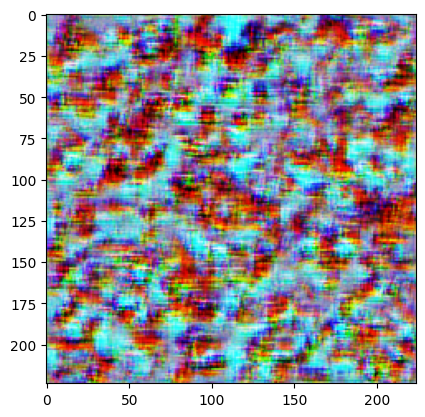

In [6]:
plt.imshow(img_en.detach().squeeze(0).permute(1, 2, 0))